In [4]:
import h5py
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [5]:
filename = "camera_intrinsics.h5"
main_K, main_distortion = None, None

with h5py.File(filename, "r") as data:

    #main intrinsics
    main_K = np.array(data["fisheye"]["K"])
    main_distortion = np.array(data["fisheye"]["distortion"])

#Reference: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html
images = os.listdir("fisheye")
for file in images:
    img = cv.imread("fisheye/" + file)
    if (img is not None):
        h,  w = img.shape[:2]
        newcameramtx, roi = cv.getOptimalNewCameraMatrix(main_K, main_distortion, (w,h), 1, (w,h))
        undistorted = cv.undistort(img, main_K, main_distortion, None, newcameramtx)

        # crop image
        x, y, w, h = roi
        undistorted = undistorted[y:y+h, x:x+w]

        new_name = "proc_fish/proc_" + file
        cv.imwrite(new_name, undistorted)
    

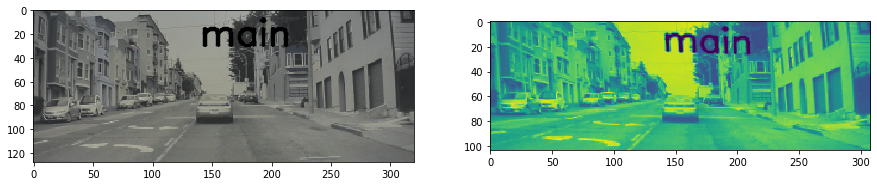

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

dist = cv.imread("car_images/0613.png")
undist = cv.imread("proc_images/proc_0613.png")
gray = cv.cvtColor(undist, cv.COLOR_BGR2GRAY)
ax[0].imshow(dist)
ax[1].imshow(gray)

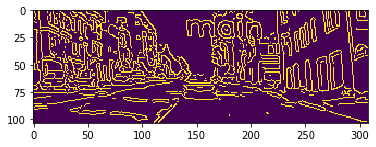

In [7]:
# (Unsuccessful) Canny Filter
blur_gray = cv.GaussianBlur(gray,(3, 3), 0)
img_can = cv.Canny(blur_gray, 45, 50)
plt.imshow(img_can)

In [8]:
#apply sobel https://medium.com/swlh/computer-vision-advanced-lane-detection-through-thresholding-8a4dea839179
sobel = cv.Sobel(gray, cv.CV_64F, 1, 1)
abs_sobel = np.absolute(sobel)
scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

sxbinary = np.zeros_like(scaled_sobel) #threshold mask
sxbinary[(scaled_sobel >= 25) & (scaled_sobel <= 100)] = 1
binary = sxbinary

Text(0.5, 1, 'Threshold in X=Y')

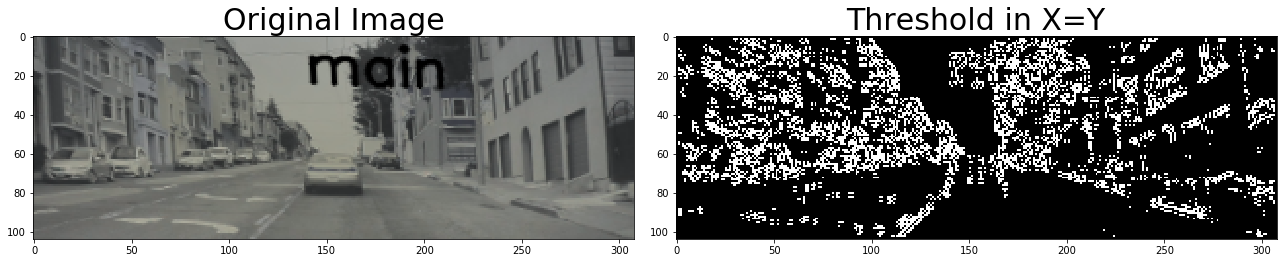

In [9]:
# Plot the result
f, ax = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()
ax[0].imshow(undist)
ax[0].set_title('Original Image', fontsize=30)
ax[1].imshow(binary, cmap='gray')
ax[1].set_title('Threshold in X=Y', fontsize=30)

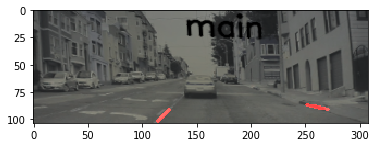

In [10]:
#Hough Lines, threshold=16, linelength > 10
#https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb

line_image = np.copy(undist) * 0  #empty img
lines = cv.HoughLinesP(binary, 1, np.pi/180, 16, np.array([]), 10, 0)

for line in lines:
    for x1,y1,x2,y2 in line:
#          if (x1 > 50 and x2 < 150):
            cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),2)

lines_edges = cv.addWeighted(undist, 0.8, line_image, 1, 0)
plt.imshow(lines_edges)